# Projet OpenClassroom 5: Segmentez les comportements de clients #

Après avoir segmenté les clients de notre jeu de données en fonction des critères d'un tableau RFM étendu, nous allons maintenant construire un algorithme afin de prédire le plus rapidement possible l'appartenance après le premier achat d'un client à l'une des catégories précédemment identifié. 

Pour cela nous allons dans un premier temps construire un premier modèle prenant uniquement en entrée les premières transactions et à partir de ces valeurs prédire l'appartenance du client à une classe. Nous évaluerons la qualité de prédiction de ce premier modèle et discuterons des améliorations à apporter pour améliorer cette prédiction dans un second modèle et troisième.


Dans le second modèle et troisième modèle, nous essayerons de déterminer à partir de quel temps après le prochain achat, nous parvenons à améliorer la prédiction. Nous rajouterons pour cela une feature fréquence sur la période considérée, une feature calculant l'étendue de la plage d'achat (date du premier achat - date du dernier achat) et enfin dans le troisième modèle, nous ajouterons une dernière dimension représentant la distance entre le premier achat d'un client et la date du dernier achat de la table de données étudiée. Dans le deuxième et troisième modèle, un paramètre MAX_DAY représentant la plage de distance étudiée après le premier achat sera entrée. Nous étudierons l'influence de ce paramètre sur la qualité de notre prédiction.

Nous conclurons ensuite sur la qualité de prédiction de nos modèles et sur la stratégie à adopter pour maximiser les ventes de l'entreprise considéré.


In [224]:
## Librairie standard:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import datetime, date, timedelta
import itertools
import pickle

## Librairie sklearn:

from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score, precision_score

## Librairie personnelle :
import plot_function
import pre_treatment


MAX_DAY = 180

## Importation des données et traitement préliminaires :##

In [192]:
table_travail = pd.read_csv("table_project_EDA.csv", sep=",", 
                            engine="python", encoding='utf-8')
table_travail.drop("Unnamed: 0", axis=1, inplace=True)
table_rfm = pd.read_csv("table_rfm.csv", sep=",", 
                        engine="python", encoding='utf-8')

In [193]:
table_rfm.set_index(["CustomerID"], inplace=True)

In [194]:
table_travail["InvoiceDate"] = \
    table_travail["InvoiceDate"].apply(lambda x: 
                                       datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [195]:
table_travail["Label"] = \
table_travail["CustomerID"].apply(lambda x: pre_treatment.fill_label(x, table_rfm))

In [196]:
table_travail.dropna(subset=["Label"], how="any", inplace=True)

### Création d'une feature Occurence et Dist_first_trans: ###

Nous allons créer deux features dans notre table de travail: une feature Occurence indiquant pour un client et pour chaque transaction le numéro d'une transaction pour ce client. Une feature dist_first_trans qui pour chaque transaction d'un client va lui associer la distance en jour à la première transaction de ce client.

In [197]:
table_travail = pre_treatment.create_feature_occ_dist(table_travail)

In [198]:
table_travail.to_csv("table_preparation.csv", sep=",", encoding='utf-8')

## Classification des clients le plus rapidement après le premier achat:  développement d'un second modèle ###

Nous allons maintenant construire notre table de données d'entrée à partir du premier achat effectué par un client ainsi que des informations accumulés MAX_DAY après leur premier achat.

### Création d'une table de hachage des labels des clients : ### 

In [199]:
table_hash_label = table_rfm["Label"]

### Création de la table de données d'entrée: ###

Nous allons dans ce second modèle reprendre les caractéristiques prises dans le 1er modèle et les compléter par des informations accumulées en fonction d'un nombre de jours MAX_DAY après le premier achat du client considéré.

Ainsi nous compléterons les caractéristiques du modèle 1 avec:
- le nombre d'achats sur la période entre le 1er achat et un nombre de jours MAX_DAY, cette feature sera nommée Frequency.
- la distance en jours entre la date du 1er achat et le dernier achat sur la période considérée, cette feature sera nommée Periode.
- le montant total d'achat sur la période considérée, cette feature sera nommée TotalAmount.

In [201]:
table_first_trans = \
    pre_treatment.transform_extraction(table_travail, 
                                       MAX_DAY, 
                                       list(table_hash_label.index))

In [202]:
table_first_trans.head()

,Label,Month,Is_UK,Product_nb,UnitPriceMin,UnitPriceMax,UnitPriceMean,AmountSum,AmountMin,AmountMax,...,QuantitySum,QuantityMin,QuantityMax,QuantityMean,Discount,Manual,POST,Frequency,Periode,TotalAmount
12680,3,8,0,19,0.29,4.15,1.859474,275.78,5.04,23.4,...,228,4,36,12.000000,0,0,0,4,113,790.81
13113,1,12,1,10,0.85,10.95,3.204000,372.97,8.50,175.2,...,105,5,16,10.500000,0,0,0,16,174,4467.66
15804,1,5,1,34,0.14,12.75,4.055882,525.36,3.36,24.9,...,314,1,48,9.235294,0,0,0,10,161,3237.10
17581,1,12,1,31,0.55,12.75,2.551613,668.40,8.50,53.1,...,375,2,24,12.096774,0,0,0,9,159,3029.56
12713,3,12,0,37,0.42,11.95,2.084595,794.55,5.04,71.7,...,505,4,25,13.648649,0,0,0,1,0,794.55


** Figure 001: ** Visualisation des 5 premières lignes de notre table des premières transactions.

### Traitement des données catégorielles et numériques ###

Nous allons maintenant procéder à la transformation de la variable "Month" en transformant cette variable en 12 variables dummie. Pour les données numériques, nous allons standardiser ces données.

In [203]:
list_col_to_std = ['Is_UK', 'Product_nb', 'UnitPriceMin',
       'UnitPriceMax', 'UnitPriceMean', 'AmountSum', 'AmountMin', 'AmountMax',
       'AmountMean', 'QuantitySum', 'QuantityMin', 'QuantityMax',
       'QuantityMean','Discount',"Manual","POST","Frequency", "Periode", "TotalAmount"]

In [204]:
table_travail2 =  pre_treatment.standardize_table(table_first_trans,
                                                  list_col_to_std, MAX_DAY)

In [205]:
y = table_travail2["Label"].values
table_travail2.drop(['Label'], axis=1, inplace=True)
X = table_travail2.values

In [206]:
#outfile = open(f"std_scale_model2_{MAX_DAY}.pyc", 'wb')
#pickle.dump(std_scale, outfile)
#outfile.close()
###############################################################################

### Séparation du jeux de données en jeux d'entrainements et jeux de tests : ### 

In [207]:
X_train, X_test, y_train, y_test = \
model_selection.train_test_split(X, y, test_size=0.3, stratify=y)

### Evaluation des performances en prédiction de notre 1er modèle: ##

#### Utilisation d'un dummy Classifier pour estimer l'appartenance des clients à un segment : ###

In [309]:
dum = DummyClassifier(strategy="stratified")
dum.fit(X_train, y_train)
print(f"Le score d'un classifieur aléatoire est de"
      f" {round(dum.score(X_test, y_test), 4) * 100} %")

Le score d'un classifieur aléatoire est de 27.32 %


#### Utilisation d'un algorithme KNN Classifier multi-classe avec validation croisée : ###

In [209]:
knn = KNeighborsClassifier()
params_knn = {'n_neighbors': list((int(x) for x in np.linspace(5, 70, 14))),
              'weights': ['uniform', 'distance'], 'p': [1, 2]}
neigh = GridSearchCV(knn, params_knn, cv=5, scoring="accuracy", 
                     return_train_score=True)
neigh.fit(X_train, y_train) 
print(f"Le meilleur résultat est obtenu pour {neigh.best_params_}")

Le meilleur résultat est obtenu pour {'n_neighbors': 10, 'p': 1, 'weights': 'distance'}


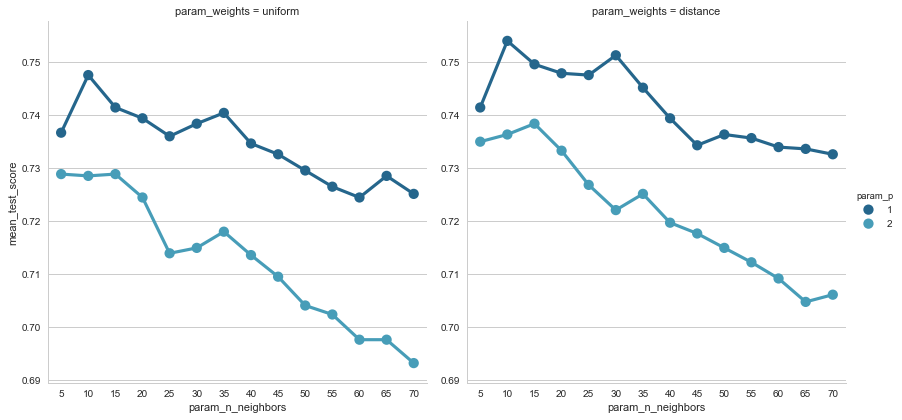

In [210]:
df_results = pd.DataFrame(neigh.cv_results_)[["mean_test_score",
                                              "param_n_neighbors",
                                              "param_p",
                                              "param_weights"]]

sns.set(style="whitegrid")
sns.factorplot(x="param_n_neighbors", y="mean_test_score",
               hue="param_p", col="param_weights", data=df_results,
               capsize=.2, palette="YlGnBu_d", size=6, aspect=1)
plt.show()


** Figure 002:**   Visualisation des résultats de la validation croisée effectuée sur notre classifier multi-classe KNN.

In [211]:
print(f"Le score d'un classifieur KNN est de" 
      f" {round(neigh.score(X_test, y_test), 4) * 100} %")

Le score d'un classifieur KNN est de 76.25 %


### Utilisation d'un algorithme de classification multi-class LogisticRegression : ### 

In [212]:
lr = LogisticRegression(max_iter=500)
params_lr = {'C': np.logspace(-3, 1, 10) , 
             'penalty': ['l1', 'l2'], 'solver': ['liblinear']}
log_reg = GridSearchCV(lr, params_lr, cv=5, scoring="accuracy",
                       return_train_score=True)
log_reg.fit(X_train,y_train)
print(f"Le meilleur résultat est obtenu pour {log_reg.best_params_}")

Le meilleur résultat est obtenu pour {'C': 0.46415888336127775, 'penalty': 'l1', 'solver': 'liblinear'}


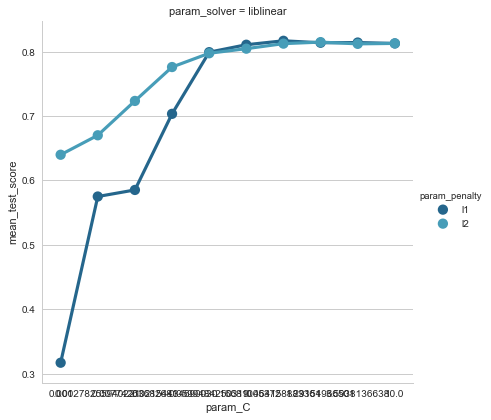

In [213]:
df_results = pd.DataFrame(log_reg.cv_results_)[["mean_test_score",
                                                "param_C",
                                                "param_penalty",
                                                "param_solver"]]
sns.factorplot(x="param_C", y="mean_test_score", hue="param_penalty", 
               col="param_solver", data=df_results, capsize=.2, 
               palette="YlGnBu_d", size=6, aspect=1)
plt.show()

** Figure 003:**   Visualisation des résultats de la validation croisée effectuée sur notre régression logistique.

In [214]:
print(f"Le score d'un classifieur de type régression logistique"
      f" est de {round(log_reg.score(X_test,y_test), 4) * 100} %")

Le score d'un classifieur de type régression logistique est de 82.74000000000001 %


### Utilisation d'un algorithme Support Vector Classifier: ###

In [215]:
svc = LinearSVC(dual=False)
params_svc = {'C': np.logspace(-3, 1, 8), 
              'penalty': ['l1','l2'], 'loss': ['squared_hinge']}
sv_classifier = GridSearchCV(svc, params_svc, cv=5,
                             scoring="accuracy", return_train_score=True)
sv_classifier.fit(X_train,y_train)
print(f"Le meilleur résultat est obtenu pour {sv_classifier.best_params_}")

Le meilleur résultat est obtenu pour {'C': 0.71968567300115138, 'loss': 'squared_hinge', 'penalty': 'l1'}


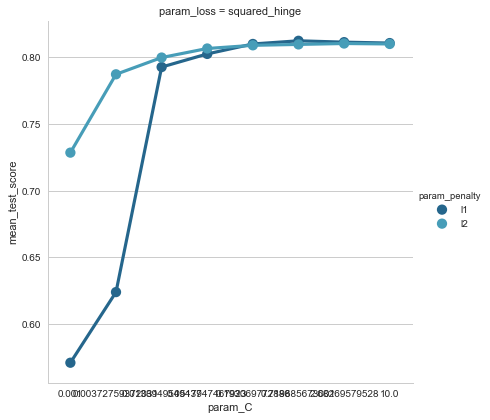

In [216]:
df_results = pd.DataFrame(sv_classifier.cv_results_)[["mean_test_score",
                                                      "param_C",
                                                      "param_penalty",
                                                      "param_loss"]]
sns.factorplot(x="param_C", y="mean_test_score", hue="param_penalty", 
               col="param_loss", data=df_results, capsize=.2,
               palette="YlGnBu_d", size=6, aspect=1)
plt.show()

** Figure 004:**   Visualisation des résultats de la validation croisée effectuée de notre algorithme SVC.

In [217]:
print(f"Le score d'un classifieur de type support vecteur"
      f" est de {round(sv_classifier.score(X_test,y_test), 4) * 100} %")

Le score d'un classifieur de type support vecteur est de 82.42 %


### Utilisation d'un algorithme de classification multi-classe de type Gradient Boosting :  ###

In [218]:
gbc = GradientBoostingClassifier()
params_gbc = {'learning_rate': np.logspace(-3, 0, 4), 'n_estimators': [10, 100, 300],\
              'max_depth': [2,3]}
gbc_classifier = GridSearchCV(gbc, params_gbc, cv=5, 
                              scoring = "accuracy",
                              return_train_score = True)
gbc_classifier.fit(X_train,y_train)
print(f"Le meilleur résultat est obtenu pour {gbc_classifier.best_params_}")

Le meilleur résultat est obtenu pour {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}


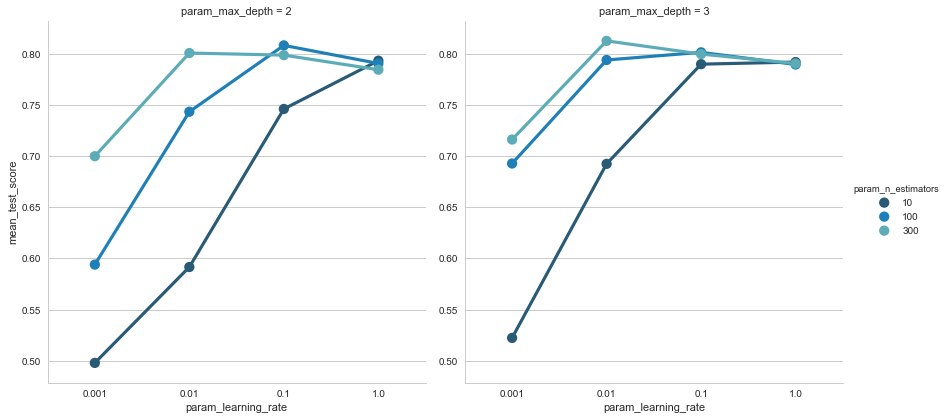

In [219]:
df_results = pd.DataFrame(gbc_classifier.cv_results_)[["mean_test_score",
                                                       "param_learning_rate",
                                                       "param_n_estimators",
                                                       "param_max_depth"]]
sns.factorplot(x="param_learning_rate", y="mean_test_score", 
               hue="param_n_estimators", col="param_max_depth", 
               data=df_results, capsize=.2, palette="YlGnBu_d", 
               size=6, aspect=1)
plt.show()


** Figure 005:**   Visualisation des résultats de la validation croisée effectuée de notre algorithme gradient boosting classifier.

In [220]:
print(f"Le score d'un classifieur de type gradient boosting"
      f" est de {round(gbc_classifier.score(X_test,y_test), 4) * 100} %")

Le score d'un classifieur de type gradient boosting est de 83.21 %


### Vote à la majorité ###

Nous allons combiné les votes des différents classifieur utilisés en utilisant la fonction VotingClassifier de sklearn. Cela nous permettra de combiner les différents classifieurs vu précédemment et de réaliser un vote à la majorité pour renforcer notre prédiciton.

In [221]:
gbc_clf = GradientBoostingClassifier(**gbc_classifier.best_params_)
lr_clf = LogisticRegression(max_iter = 500, **log_reg.best_params_)
svm_clf = LinearSVC(dual=False, **sv_classifier.best_params_)
knn_clf = KNeighborsClassifier(**neigh.best_params_)

In [222]:
vot_clf = VotingClassifier(estimators = [('gbc',gbc_clf),
                                         ('lr',lr_clf),
                                         ('svm',svm_clf)], 
                           voting = 'hard')
vot_clf.fit(X_train,y_train)
vot_clf.score(X_test, y_test)

0.82739509105304831

In [223]:
outfile = open(f"clf_prediction_{MAX_DAY}.pyc", 'wb')
pickle.dump(vot_clf, outfile)
outfile.close()

Normalized confusion matrix


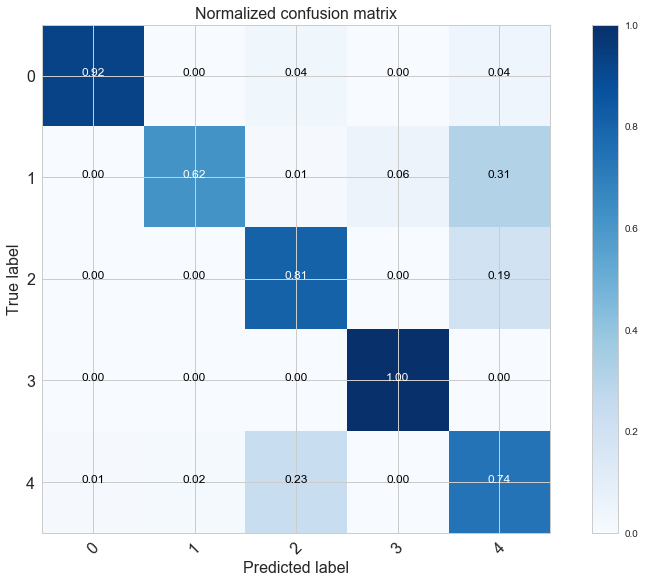

In [310]:
class_names = [0, 1, 2, 3, 4]
y_pred = vot_clf.fit(X_train, y_train).predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(12, 8))
plot_function.plot_confusion_matrix(cnf_matrix, classes=class_names, 
                                    normalize=True,
                                    title='Normalized confusion matrix')

plt.show()

**Figure 006: ** Matrice de confusion des résultats obtenus par notre classifieur combiné à partir des features de notre second modèle.

In [251]:
a = recall_score(y_test, y_pred, labels=class_names, average=None)
b = precision_score(y_test, y_pred, labels=class_names, average=None)
c = f1_score(y_test, y_pred, labels=class_names, average=None)

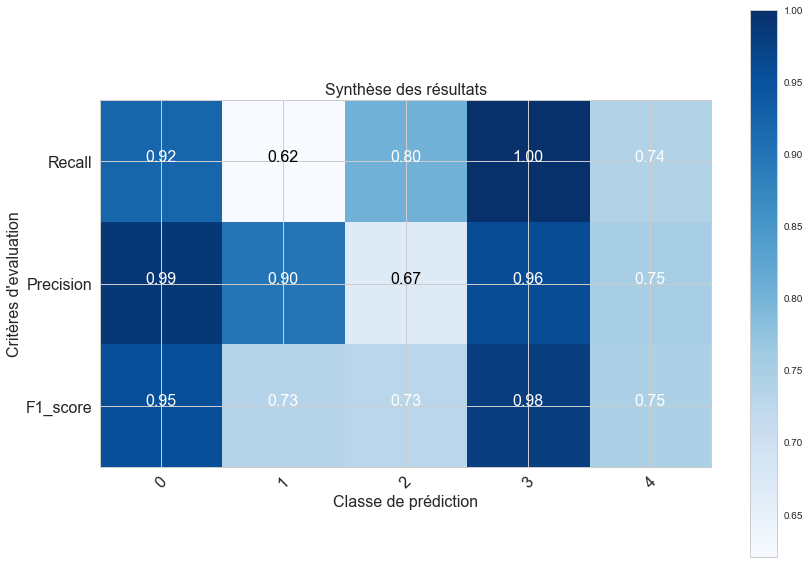

In [306]:
plot_function.plot_resultats(a, b, c, class_names)

** Figure 008 : ** Synthèse des résultats de notre classifieur selon les critères de recall, de la précision et du F1_score.

## Conclusion de ce deuxième modèle : ##

Nous pouvons ainsi remarquer que notre modèle est capable très rapidement (au bout de 90 jours) de déterminer avec un score supérieur à 90% les catégories de clients de classe 0 (les nouveaux clients) et de classe 3 (les clients étrangers). Pour le reste des classes, il sera difficile pour notre modèle de prédire à 90 jours, l'appartenance d'un client à la catégorie 1,2 ou 4. Il faudra certainement davantage de temps afin de pouvoir distinguer ces catégories plus finement. Ce point sera l'objet du complément ci-dessous.

## Rôle et influence du paramètre MAX_DAY : ##

Nous allons approfondir ce second modèle afin de déterminer la valeur du paramètre MAX_DAY nous permettant d'obtenir un score de prédiction suffisamment important (> 90%) sur chacune de nos classes ainsi définis.

In [186]:
list_max_day = [30, 60, 90, 120, 150, 180, 
                210, 240, 270, 300, 330, 360]
lmd = len(list_max_day)
list_results = []
list_matrix = []

In [187]:
for day in list_max_day:
    table_prediction_temp = pre_treatment.transform_extraction(table_travail, day, list(table_hash_label.index))
    table_prediction_temp = pre_treatment.standardize_table(table_prediction_temp, list_col_to_std, day)
    score = pre_treatment.evaluate_model_max_day(table_prediction_temp, list_matrix)
    list_results.append(score)

In [188]:
cm = [list_matrix[i].astype('float') / list_matrix[i].sum(axis=1)
      [:, np.newaxis] for i in range(lmd)]
list_class = [[cm[i][j,j] for i in range(lmd)]for j in range(5)]

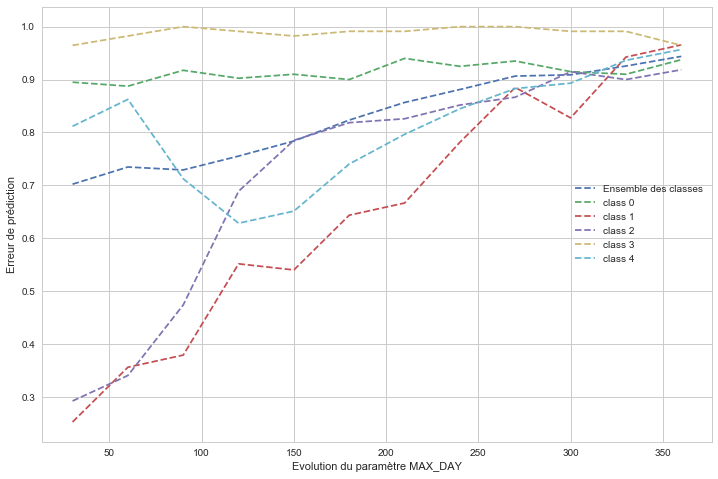

In [189]:
fig = plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 16})
plt.plot(list_max_day, list_results, 
         label='Ensemble des classes', linestyle='dashed')
plt.plot(list_max_day,list_class[0], label='class 0', 
         linestyle='dashed')
plt.plot(list_max_day,list_class[1], label='class 1',
         linestyle='dashed')
plt.plot(list_max_day,list_class[2], label='class 2',
         linestyle='dashed')
plt.plot(list_max_day,list_class[3], label='class 3',
         linestyle='dashed')
plt.plot(list_max_day,list_class[4], label='class 4',
         linestyle='dashed')
plt.legend(loc='center right')
plt.xlabel('Evolution du paramètre MAX_DAY')
plt.ylabel('Erreur de prédiction')

plt.show()

**Figure 009: ** Evolution des erreurs de prédiction de notre modèle par classe et au total pour différentes valeurs de MAX_DAY.

## Conclusion de notre travail et perspective : ##

Nous avons ainsi dans notre travail de modélisation développé deux modèles de prédiction: un premier modèle basé sur les premières transactions, un second modèle basé sur les premières transactions complétées de features représentant la fréquence d'achats, le montant total des achats et l'étendue de la plage d'achats client.

Nous avons vu que le modèle basé sur les premieres transactions n'étaient pas capable de prédire les catégories de client dont le comportement était basé sur la fréquence d'achat ou des caractéristiques comme la récence ou la latence des achats.

Nous avons étendu notre premier modèle pour inclure des données mesurant avec le temps des caractéristiques proches de la fréquence d'achat, du montant total des achats et de l'étendue de la période d'achat du client. Nous avons vu qu'il fallait un temps important pour pouvoir distinguer les catégories de clients avec un score de prédiction ("accuracy_score") supérieur à 90%. Une catégorie ne peut pas être prédite rapidement par notre modèle, il s'agit de la catégorie des clients perdus qui par définition qui ne pourront s'observer qu'à partir d'une période temporelle importante de non achat.

Notre modèle permet néanmoins dès le premier achat de pouvoir distinguer rapidement les nouveaux clients avec un score de prédiction supérieurs à 90%, cela peut permettre de cibler très rapidement cette catégorie (sans conserver de données clients) afin d'aller accompagner ces clients dans leur première phase d'achats sur le site.

En complément à ce travail, il conviendrait :

- de rajouter des catégories de produits afin de pouvoir cibler spécifiquement certains produits.
- de compléter notre travail à continuant à travailler sur des features permettant de mieux détecter nos classes de clients.